# Brain Tumor Detector

## Get and Load Dataset

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [3]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=810c030a-1798-471d-8daf-399fa76a521d
To: /content/brain_tumor.zip
100% 156M/156M [00:22<00:00, 6.98MB/s]


In [4]:
!unzip -q brain_tumor.zip

In [5]:
ls -l

total 152152
-rw-r--r-- 1 root root 155791278 Apr  5 02:30 brain_tumor.zip
drwxr-xr-x 1 root root      4096 Jun 13 13:28 sample_data/
drwxr-xr-x 6 root root      4096 Jun 15 10:33 Testing/
drwxr-xr-x 6 root root      4096 Jun 15 10:33 Training/


In [6]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (38.0 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 121913 files and directories currently instal

In [7]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

./Training/
├── glioma  [1321 entries exceeds filelimit, not opening dir]
├── meningioma  [1339 entries exceeds filelimit, not opening dir]
├── notumor  [1595 entries exceeds filelimit, not opening dir]
└── pituitary  [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [8]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

./Testing/
├── glioma  [300 entries exceeds filelimit, not opening dir]
├── meningioma  [306 entries exceeds filelimit, not opening dir]
├── notumor  [405 entries exceeds filelimit, not opening dir]
└── pituitary  [300 entries exceeds filelimit, not opening dir]

4 directories, 0 files


## Load Dependencies

In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.15.0


In [10]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

## Utility functions to create dataset generators

In [11]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [12]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


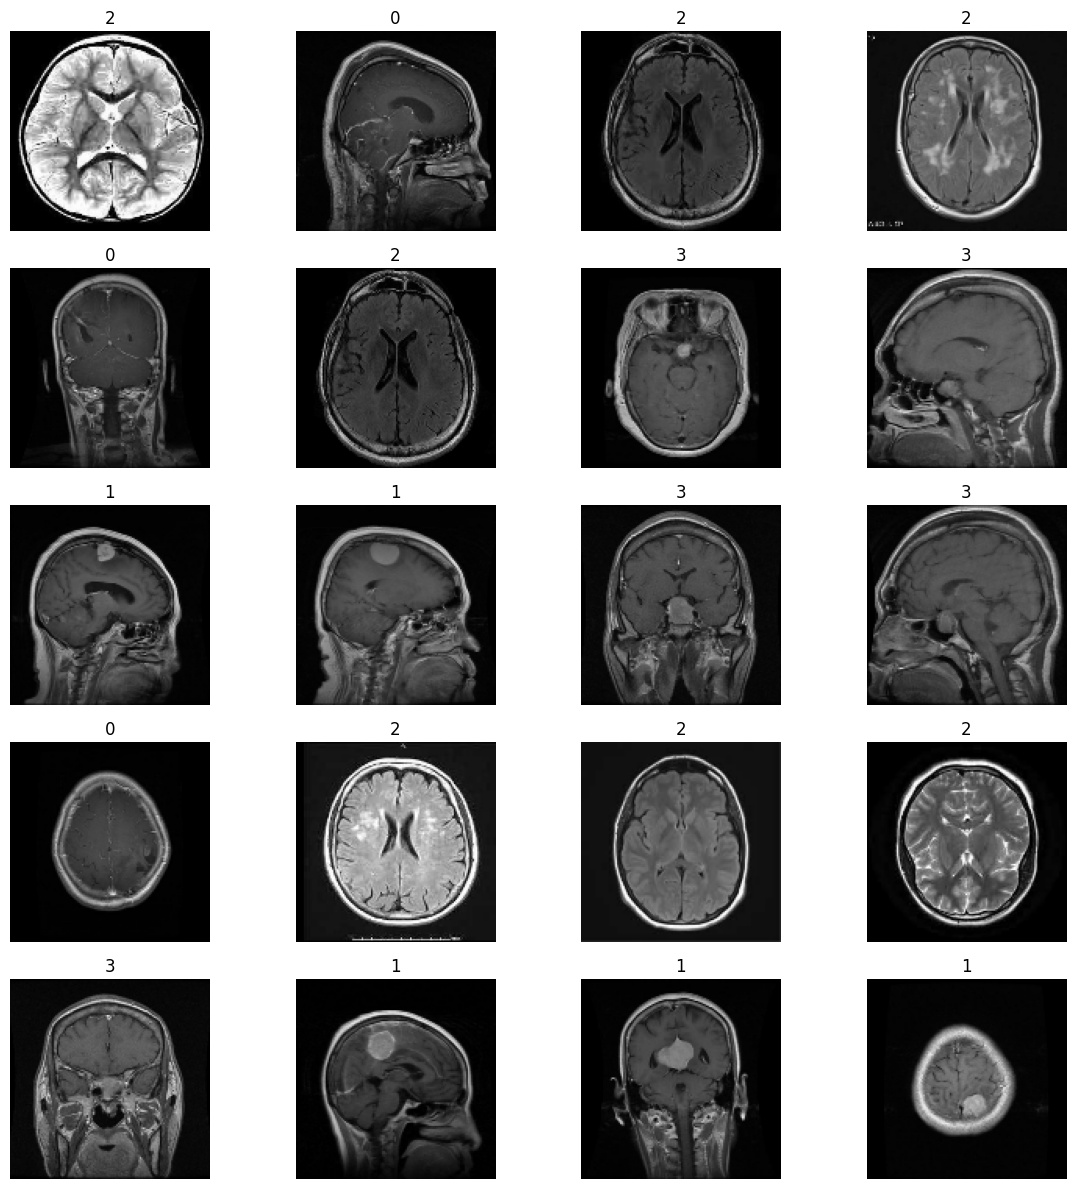

In [13]:
plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

In [14]:
mkdir models

In [15]:
recall_dict = {}
f1_weighted_dict = {}



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 128)               16257152  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                        

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:12,  1.26s/it]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:05,  1.68it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:03,  2.52it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:02,  3.42it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.04it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:02<00:01,  4.67it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:02<00:00,  5.46it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  5.85it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.32it/s]

1/1 [==============================] - 0s 166ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


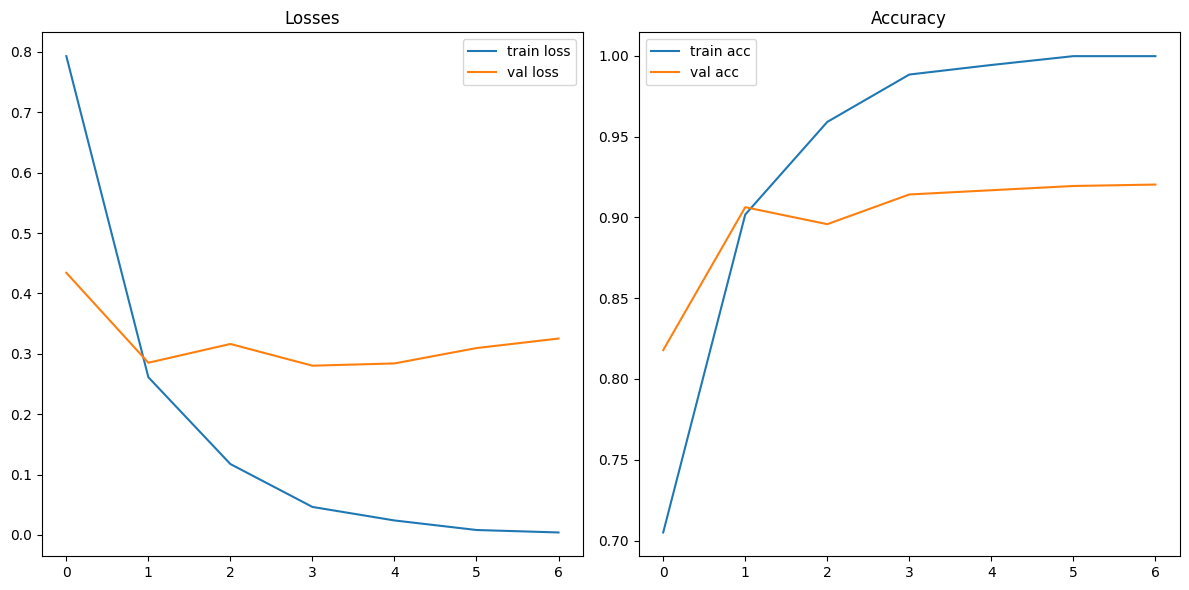

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])


model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

In [17]:
report = classification_report(test_labels, predicted_labels, target_names=classes, output_dict=True)

# Extract meningioma recall
meningioma_recall = report['meningioma']['recall']

# Extract weighted average F1-score
weighted_f1 = report['weighted avg']['f1-score']

recall_dict['CNN_1Layer_Conv2D'] = meningioma_recall
f1_weighted_dict['CNN_1Layer_Conv2D'] = weighted_f1

In [18]:
recall_dict

{'CNN_1Layer_Conv2D': 0.8137254901960784}

In [19]:
train_ds, val_ds = prepare_train_and_val_datasets()

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])


model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                   

Epoch 1/20
143/143 [==============================] - 10s 41ms/step - loss: 0.7109 - accuracy: 0.7094 - val_loss: 0.5053 - val_accuracy: 0.8152
Epoch 2/20
143/143 [==============================] - 6s 38ms/step - loss: 0.3256 - accuracy: 0.8729 - val_loss: 0.4430 - val_accuracy: 0.8485
Epoch 3/20
143/143 [==============================] - 6s 40ms/step - loss: 0.1894 - accuracy: 0.9313 - val_loss: 0.2824 - val_accuracy: 0.9107
Epoch 4/20
143/143 [==============================] - 6s 43ms/step - loss: 0.1038 - accuracy: 0.9630 - val_loss: 0.2859 - val_accuracy: 0.9116
Epoch 5/20
143/143 [==============================] - 8s 52ms/step - loss: 0.0603 - accuracy: 0.9803 - val_loss: 0.2908 - val_accuracy: 0.9194
Epoch 6/20
143/143 [==============================] - 6s 39ms/step - loss: 0.0393 - accuracy: 0.9873 - val_loss: 0.3521 - val_accuracy: 0.9063
Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:10,  1.09s/it]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.92it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.90it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.92it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.81it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.52it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.65it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.74it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.58it/s]

1/1 [==============================] - 0s 223ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.23it/s]

              precision    recall  f1-score   support

      glioma       0.89      0.88      0.88       300
  meningioma       0.85      0.76      0.80       306
     notumor       0.93      0.99      0.95       405
   pituitary       0.96      0.98      0.97       300

    accuracy                           0.91      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.91      0.91      0.91      1311



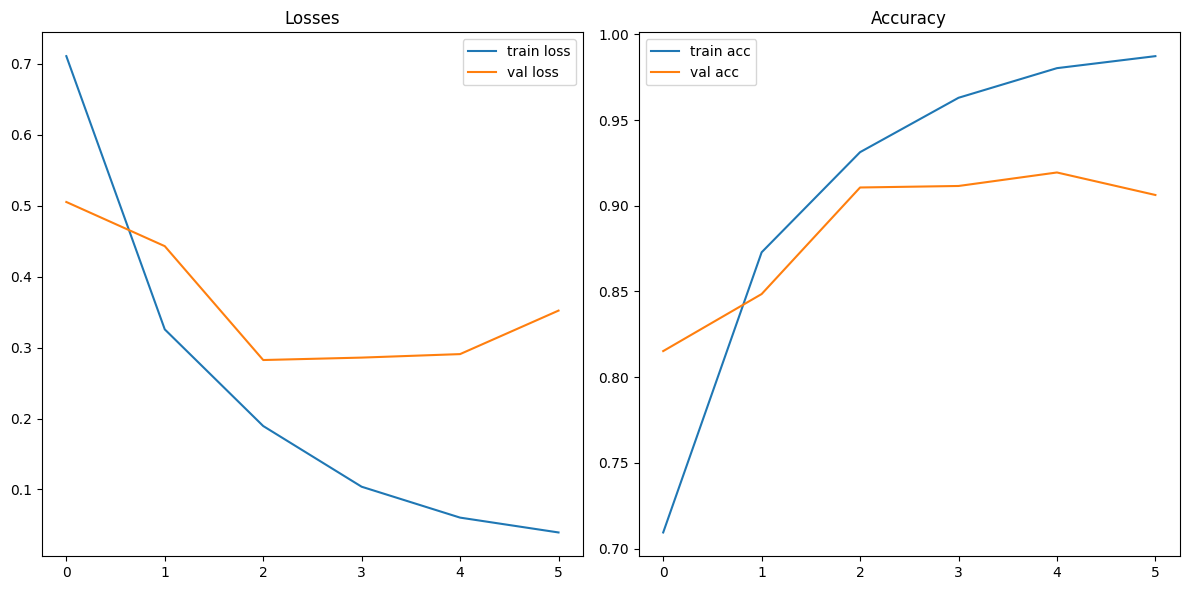

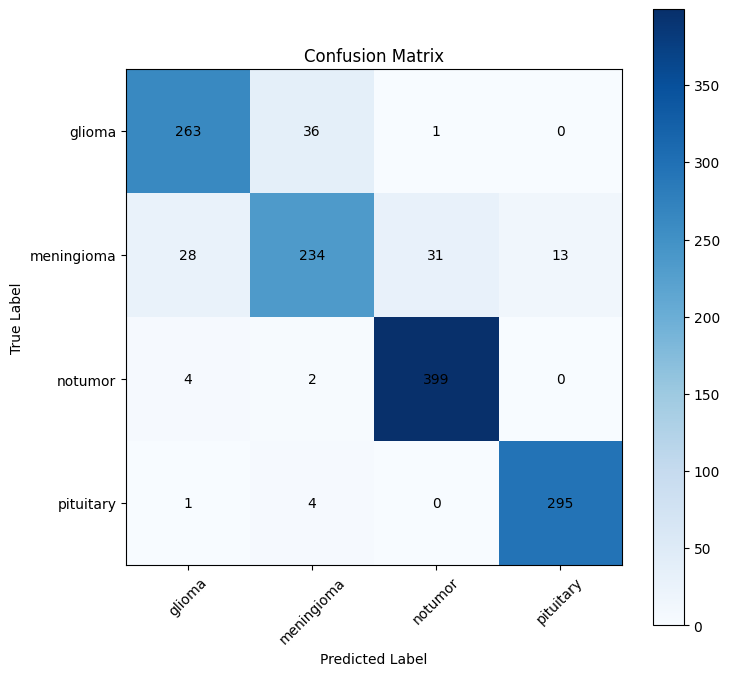

In [20]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='train acc')
plt.plot(history1.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions1 = eval_model_on_test(model)

# get the predicted labels

predicted_labels1 = np.argmax(predictions1, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels1, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels1)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('models/brain_tumor_classifier_v1.keras')



In [21]:
report1 = classification_report(test_labels, predicted_labels1, target_names=classes, output_dict=True)

# Extract meningioma recall
meningioma_recall = report1['meningioma']['recall']

# Extract weighted average F1-score
weighted_f1 = report1['weighted avg']['f1-score']

recall_dict['CNN_2Layer_Conv2D'] = meningioma_recall
f1_weighted_dict['CNN_2Layer_Conv2D'] = weighted_f1

recall_dict

{'CNN_1Layer_Conv2D': 0.8137254901960784,
 'CNN_2Layer_Conv2D': 0.7647058823529411}

In [22]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.9223009470740805,
 'CNN_2Layer_Conv2D': 0.9065875564338557}

In [23]:
train_ds, val_ds = prepare_train_and_val_datasets()

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                   

Epoch 1/20
143/143 [==============================] - 7s 35ms/step - loss: 0.7131 - accuracy: 0.7208 - val_loss: 0.4958 - val_accuracy: 0.8056
Epoch 2/20
143/143 [==============================] - 7s 48ms/step - loss: 0.3997 - accuracy: 0.8435 - val_loss: 0.4775 - val_accuracy: 0.8187
Epoch 3/20
143/143 [==============================] - 6s 38ms/step - loss: 0.3118 - accuracy: 0.8845 - val_loss: 0.3267 - val_accuracy: 0.8862
Epoch 4/20
143/143 [==============================] - 8s 54ms/step - loss: 0.2310 - accuracy: 0.9158 - val_loss: 0.2952 - val_accuracy: 0.9054
Epoch 5/20
143/143 [==============================] - 6s 41ms/step - loss: 0.1513 - accuracy: 0.9475 - val_loss: 0.2905 - val_accuracy: 0.9028
Epoch 6/20
143/143 [==============================] - 7s 50ms/step - loss: 0.1226 - accuracy: 0.9556 - val_loss: 0.2762 - val_accuracy: 0.9256
Epoch 7/20
143/143 [==============================] - 7s 51ms/step - loss: 0.0796 - accuracy: 0.9726 - val_loss: 0.2794 - val_accuracy: 0.9282

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:11,  1.13s/it]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.87it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.68it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.47it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.32it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.71it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  6.38it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.52it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.60it/s]

1/1 [==============================] - 0s 139ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]

              precision    recall  f1-score   support

      glioma       0.95      0.93      0.94       300
  meningioma       0.92      0.90      0.91       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



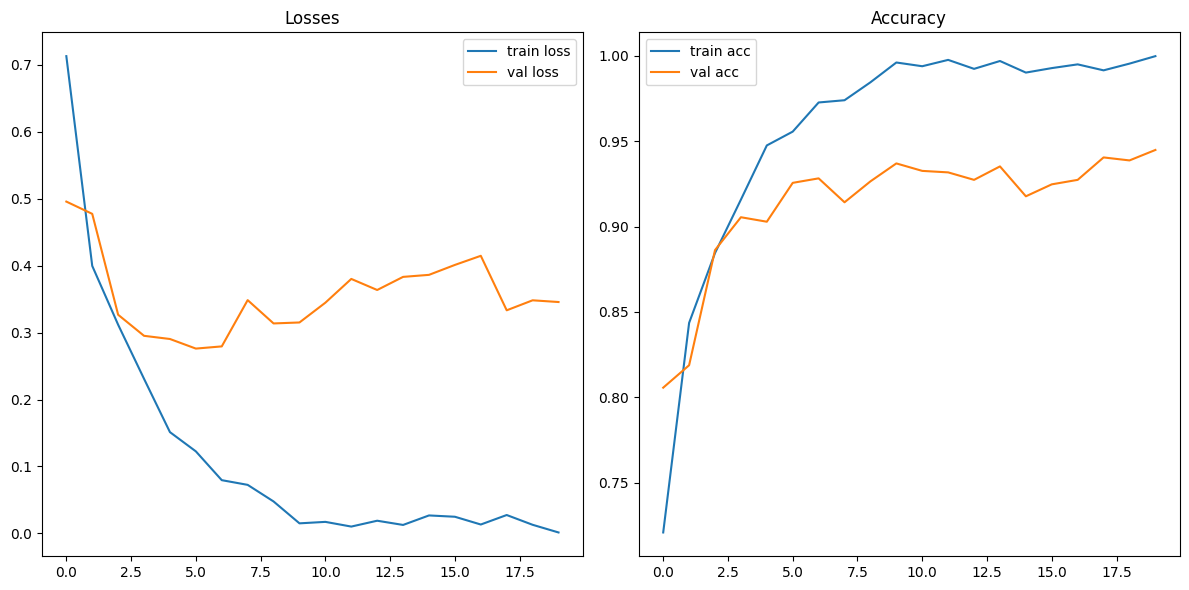

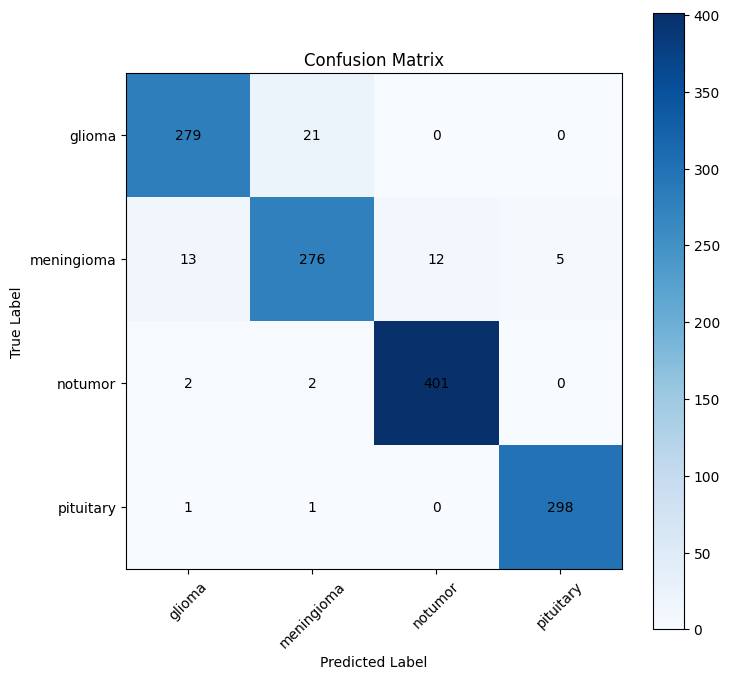

In [24]:
# tarin the model

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions2 = eval_model_on_test(model)

# get the predicted labels

predicted_labels2 = np.argmax(predictions2, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels2, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels2)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('models/brain_tumor_classifier_v2.keras')



In [25]:
report2 = classification_report(test_labels, predicted_labels2, target_names=classes, output_dict=True)

recall_dict['CNN_3Layer_Conv2D'] = report2['meningioma']['recall']
f1_weighted_dict['CNN_3Layer_Conv2D'] = report2['weighted avg']['f1-score']

In [26]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.9223009470740805,
 'CNN_2Layer_Conv2D': 0.9065875564338557,
 'CNN_3Layer_Conv2D': 0.9562722071903722}

In [27]:
train_ds, val_ds = prepare_train_and_val_datasets()

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)



Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


Epoch 1/20
143/143 [==============================] - 9s 47ms/step - loss: 0.8126 - accuracy: 0.6597 - val_loss: 0.5928 - val_accuracy: 0.7802
Epoch 2/20
143/143 [==============================] - 6s 39ms/step - loss: 0.4559 - accuracy: 0.8269 - val_loss: 0.4904 - val_accuracy: 0.8205
Epoch 3/20
143/143 [==============================] - 7s 51ms/step - loss: 0.3499 - accuracy: 0.8700 - val_loss: 0.3391 - val_accuracy: 0.8862
Epoch 4/20
143/143 [==============================] - 6s 38ms/step - loss: 0.2661 - accuracy: 0.9007 - val_loss: 0.3282 - val_accuracy: 0.8792
Epoch 5/20
143/143 [==============================] - 6s 39ms/step - loss: 0.2043 - accuracy: 0.9228 - val_loss: 0.2695 - val_accuracy: 0.9229
Epoch 6/20
143/143 [==============================] - 7s 50ms/step - loss: 0.1549 - accuracy: 0.9446 - val_loss: 0.2546 - val_accuracy: 0.9212
Epoch 7/20
143/143 [==============================] - 6s 41ms/step - loss: 0.1085 - accuracy: 0.9632 - val_loss: 0.3768 - val_accuracy: 0.8800

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:11,  1.14s/it]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.76it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.55it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  3.98it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:01,  4.46it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:02<00:00,  4.69it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  4.96it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  5.17it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  5.31it/s]

1/1 [==============================] - 0s 192ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


              precision    recall  f1-score   support

      glioma       0.95      0.91      0.93       300
  meningioma       0.90      0.89      0.89       306
     notumor       0.94      0.99      0.97       405
   pituitary       0.97      0.97      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



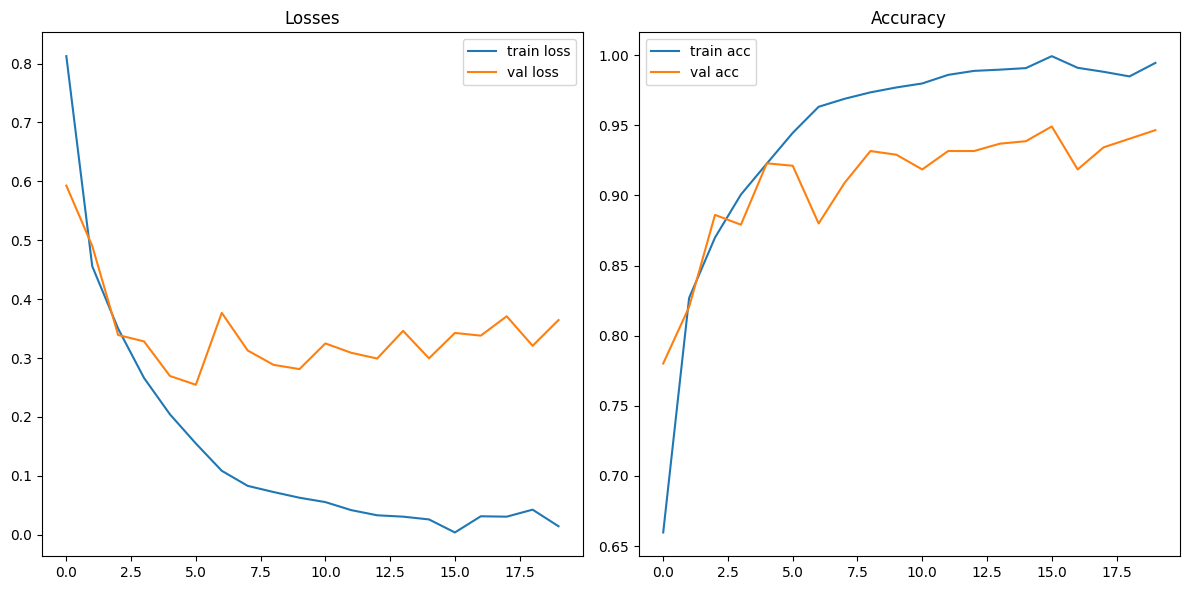

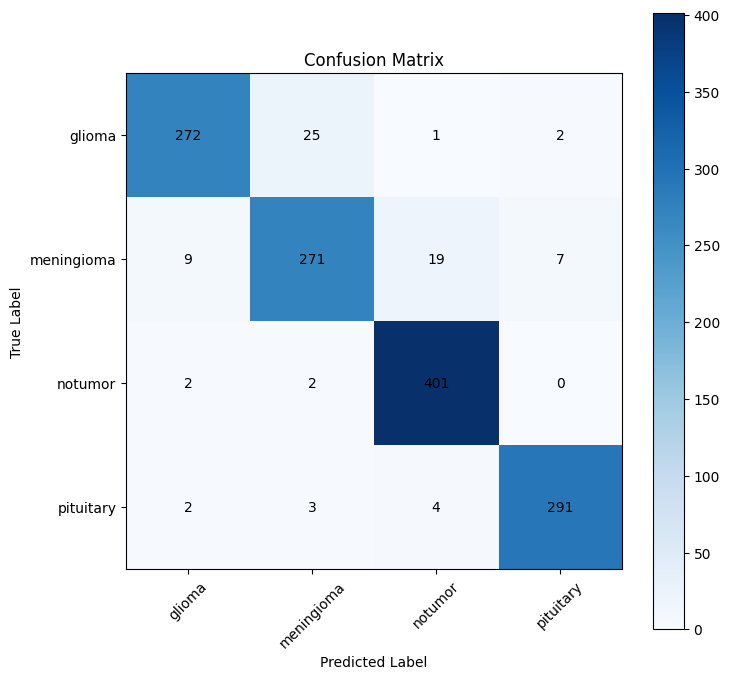

In [28]:
history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='train loss')
plt.plot(history3.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], label='train acc')
plt.plot(history3.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions3 = eval_model_on_test(model)

# get the predicted labels

predicted_labels3 = np.argmax(predictions3, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels3, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels3)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('models/brain_tumor_classifier_v3.keras')



In [29]:
report3 = classification_report(test_labels, predicted_labels3, target_names=classes, output_dict=True)

recall_dict['CNN_4Layer_Conv2D'] = report3['meningioma']['recall']
f1_weighted_dict['CNN_4Layer_Conv2D'] = report3['weighted avg']['f1-score']

In [30]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.9223009470740805,
 'CNN_2Layer_Conv2D': 0.9065875564338557,
 'CNN_3Layer_Conv2D': 0.9562722071903722,
 'CNN_4Layer_Conv2D': 0.9416811581407522}

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Epoch 1/20
143/143 [==============================] - 10s 50ms/step - loss: 0.7250 - accuracy: 0.7033 - val_loss: 0.4758 - val_accuracy: 0.8161
Epoch 2/20
143/143 [==============================] - 6s 41ms/step - loss: 0.3634 - accuracy: 0.8591 - val_loss: 0.4001 - val_accuracy: 0.8564
Epoch 3/20
143/143 [==============================] - 7s 44ms/step - loss: 0.2497 - accuracy: 0.9105 - val_loss: 0.2608 - val_accuracy: 0.9177
Epoch 4/20
143/143 [==============================] - 7s 46ms/step - loss: 0.1567 - accuracy: 0.9429 - val_loss: 0.2743 - val_accuracy: 0.9264
Epoch 5/20
143/143 [==============================] - 7s 43ms/step - loss: 0.1038 - accuracy: 0.9637 - val_loss: 0.3368 - val_accuracy: 0.9142
Epoch 6/20
143/143 [==============================] - 7s 45ms/step - loss: 0.0778 - accuracy: 0.9731 - val_loss: 0.2471 - val_accuracy: 0.

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:10,  1.07s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.89it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.80it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.76it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.20it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.64it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  6.34it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.83it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.74it/s]

1/1 [==============================] - 0s 445ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


              precision    recall  f1-score   support

      glioma       0.95      0.94      0.94       300
  meningioma       0.94      0.89      0.91       306
     notumor       0.96      0.99      0.98       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.96      1311
weighted avg       0.96      0.96      0.96      1311



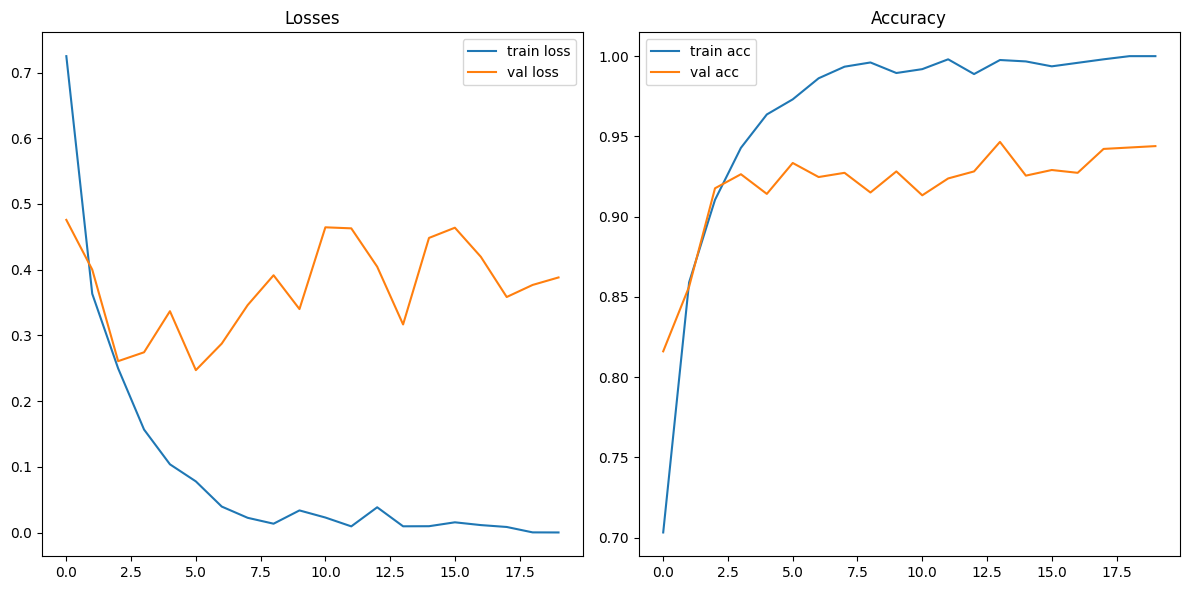

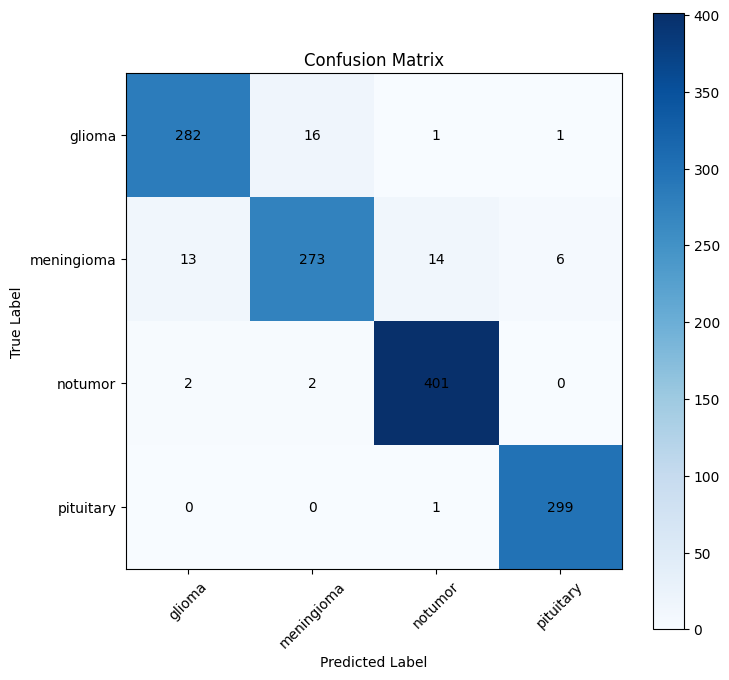

In [31]:
train_ds, val_ds = prepare_train_and_val_datasets()

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history4 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], label='train loss')
plt.plot(history4.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history4.history['accuracy'], label='train acc')
plt.plot(history4.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions4 = eval_model_on_test(model)

# get the predicted labels

predicted_labels4 = np.argmax(predictions4, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels4, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels4)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('models/brain_tumor_classifier_v4.keras')

In [32]:
report4 = classification_report(test_labels, predicted_labels4, target_names=classes, output_dict=True)

recall_dict['CNN_3LayerDeeper_Conv2D'] = report4['meningioma']['recall']
f1_weighted_dict['CNN_3LayerDeeper_Conv2D'] = report4['weighted avg']['f1-score']

In [33]:
recall_dict

{'CNN_1Layer_Conv2D': 0.8137254901960784,
 'CNN_2Layer_Conv2D': 0.7647058823529411,
 'CNN_3Layer_Conv2D': 0.9019607843137255,
 'CNN_4Layer_Conv2D': 0.8856209150326797,
 'CNN_3LayerDeeper_Conv2D': 0.8921568627450981}

In [34]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.9223009470740805,
 'CNN_2Layer_Conv2D': 0.9065875564338557,
 'CNN_3Layer_Conv2D': 0.9562722071903722,
 'CNN_4Layer_Conv2D': 0.9416811581407522,
 'CNN_3LayerDeeper_Conv2D': 0.956874119962932}

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Epoch 1/20
143/143 [==============================] - 9s 42ms/step - loss: 0.7827 - accuracy: 0.6772 - val_loss: 0.4909 - val_accuracy: 0.8179
Epoch 2/20
143/143 [==============================] - 7s 49ms/step - loss: 0.4230 - accuracy: 0.8398 - val_loss: 0.6758 - val_accuracy: 0.7680
Epoch 3/20
143/143 [==============================] - 6s 40ms/step - loss: 0.3321 - accuracy: 0.8794 - val_loss: 0.3276 - val_accuracy: 0.8870
Epoch 4/20
143/143 [==============================] - 6s 41ms/step - loss: 0.2226 - accuracy: 0.9175 - val_loss: 0.2699 - val_accuracy: 0.9159
Epoch 5/20
143/143 [==============================] - 6s 40ms/step - loss: 0.1618 - accuracy: 0.9418 - val_loss: 0.2837 - val_accuracy: 0.9098
Epoch 6/20
143/143 [==============================] - 7s 50ms/step - loss: 0.1089 - accuracy: 0.9643 - val_loss: 0.2945 - val_accuracy: 0.9

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 11ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:11,  1.12s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.82it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.76it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.60it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.29it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.72it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  5.98it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.60it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  7.07it/s]

1/1 [==============================] - 0s 138ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.38it/s]


              precision    recall  f1-score   support

      glioma       0.87      0.95      0.91       300
  meningioma       0.93      0.85      0.88       306
     notumor       0.96      0.99      0.98       405
   pituitary       0.99      0.94      0.96       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



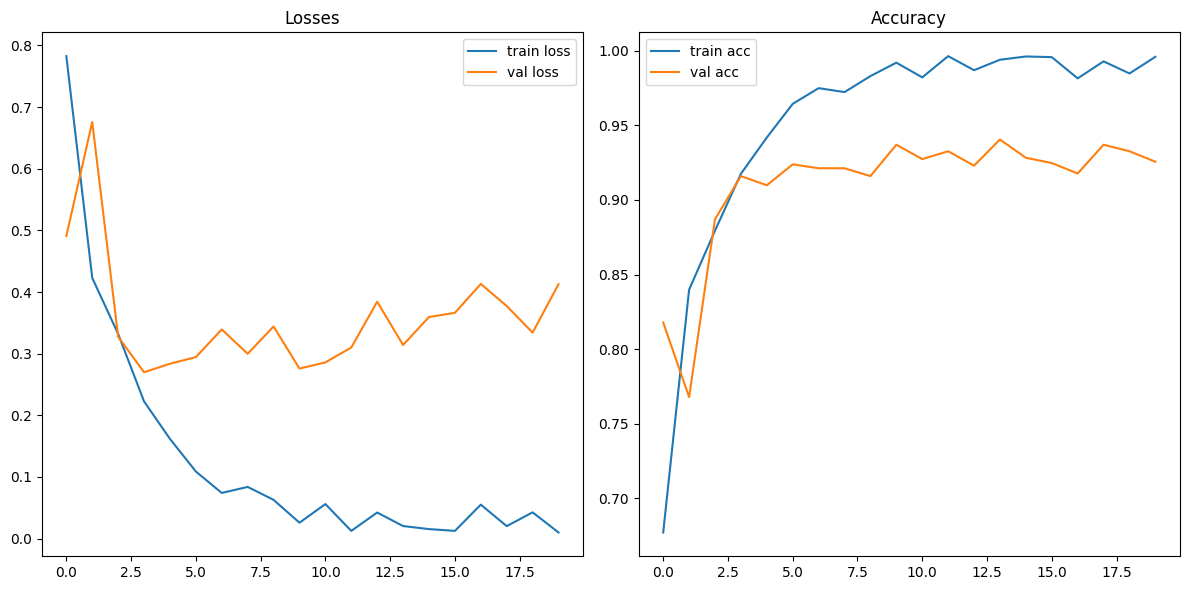

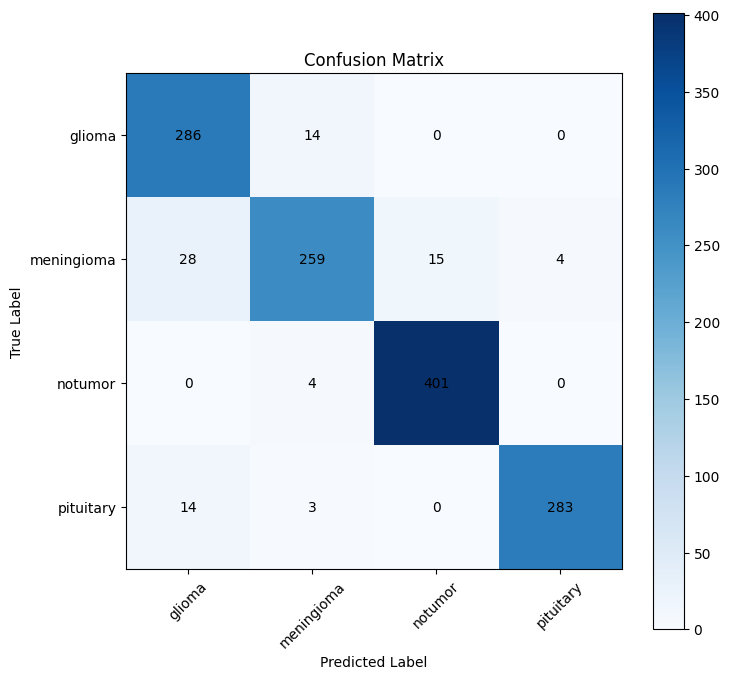

In [35]:
train_ds, val_ds = prepare_train_and_val_datasets()

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history5 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history5.history['loss'], label='train loss')
plt.plot(history5.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history5.history['accuracy'], label='train acc')
plt.plot(history5.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions5 = eval_model_on_test(model)

# get the predicted labels

predicted_labels5 = np.argmax(predictions5, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels5, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels5)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('models/brain_tumor_classifier_v5.keras')

In [36]:
report5 = classification_report(test_labels, predicted_labels5, target_names=classes, output_dict=True)

recall_dict['CNN_4LayerDeeper_Conv2D'] = report5['meningioma']['recall']
f1_weighted_dict['CNN_4LayerDeeper_Conv2D'] = report5['weighted avg']['f1-score']

In [37]:
recall_dict

{'CNN_1Layer_Conv2D': 0.8137254901960784,
 'CNN_2Layer_Conv2D': 0.7647058823529411,
 'CNN_3Layer_Conv2D': 0.9019607843137255,
 'CNN_4Layer_Conv2D': 0.8856209150326797,
 'CNN_3LayerDeeper_Conv2D': 0.8921568627450981,
 'CNN_4LayerDeeper_Conv2D': 0.8464052287581699}

In [38]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.9223009470740805,
 'CNN_2Layer_Conv2D': 0.9065875564338557,
 'CNN_3Layer_Conv2D': 0.9562722071903722,
 'CNN_4Layer_Conv2D': 0.9416811581407522,
 'CNN_3LayerDeeper_Conv2D': 0.956874119962932,
 'CNN_4LayerDeeper_Conv2D': 0.9371736237146099}

# **Data augmentation**

**Data augmentation by flipping left right**

In [39]:
# add augmentation directly to the training set like:
train_ds, val_ds = prepare_train_and_val_datasets()
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


Epoch 1/20
143/143 [==============================] - 9s 52ms/step - loss: 0.7398 - accuracy: 0.7000 - val_loss: 0.4777 - val_accuracy: 0.8240
Epoch 2/20
143/143 [==============================] - 7s 44ms/step - loss: 0.4045 - accuracy: 0.8453 - val_loss: 0.4668 - val_accuracy: 0.8354
Epoch 3/20
143/143 [==============================] - 8s 55ms/step - loss: 0.3055 - accuracy: 0.8821 - val_loss: 0.3048 - val_accuracy: 0.9089
Epoch 4/20
143/143 [==============================] - 7s 48ms/step - loss: 0.2216 - accuracy: 0.9116 - val_loss: 0.2618 - val_accuracy: 0.9063
Epoch 5/20
143/143 [==============================] - 7s 45ms/step - loss: 0.1416 - accuracy: 0.9510 - val_loss: 0.2608 - val_accuracy: 0.9264
Epoch 6/20
143/143 [==============================] - 8s 54ms/step - loss: 0.1093 - accuracy: 0.9632 - val_loss: 0.2265 - val_accuracy: 0.9370
Epoch 7/20
143/143 [==============================] - 8s 56ms/step - loss: 0.0843 - accuracy: 0.9696 - val_loss: 0.1917 - val_accuracy: 0.9448

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:10,  1.06s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.77it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.59it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.46it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.26it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.90it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  6.57it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.75it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.65it/s]

1/1 [==============================] - 0s 78ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]

              precision    recall  f1-score   support

      glioma       0.98      0.94      0.96       300
  meningioma       0.93      0.93      0.93       306
     notumor       0.96      0.99      0.98       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



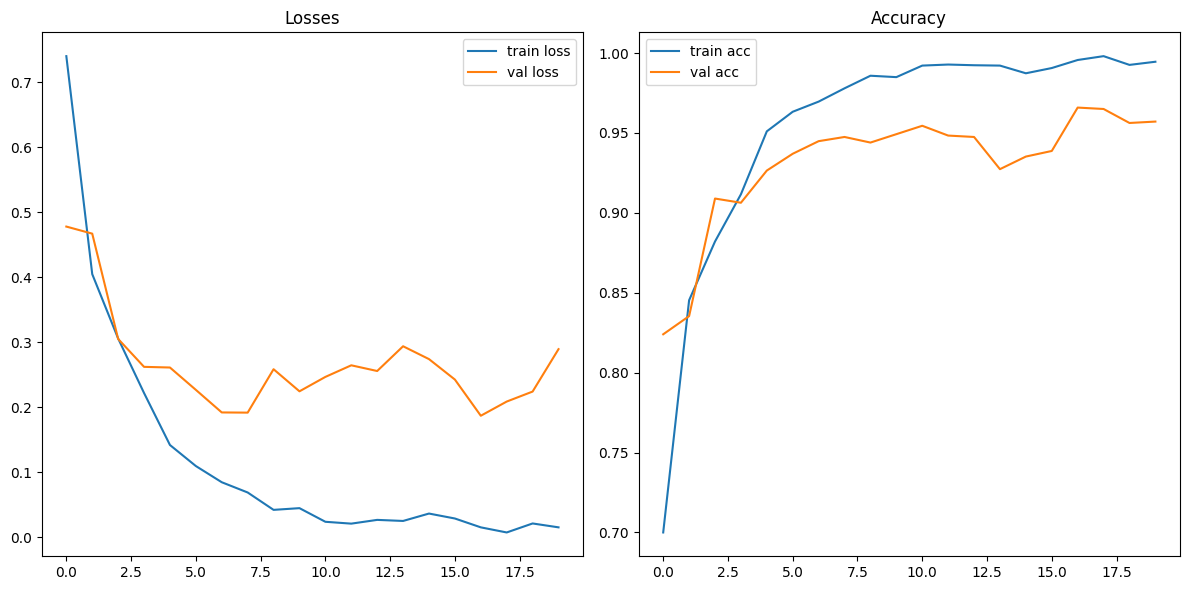

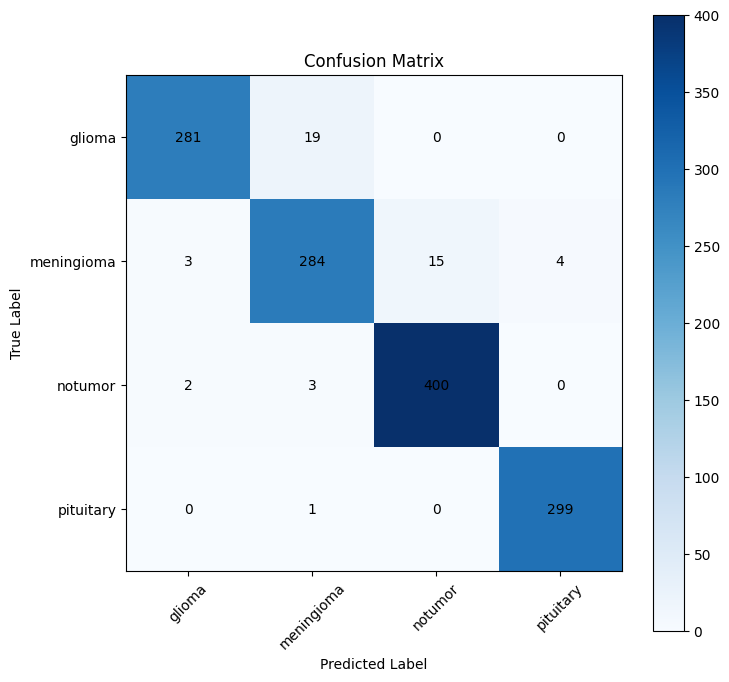

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# tarin the model

history6 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history6.history['loss'], label='train loss')
plt.plot(history6.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history6.history['accuracy'], label='train acc')
plt.plot(history6.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions6 = eval_model_on_test(model)

# get the predicted labels

predicted_labels6 = np.argmax(predictions6, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels6, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels6)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('models/brain_tumor_classifier_v6.keras')

In [41]:
report6 = classification_report(test_labels, predicted_labels6, target_names=classes, output_dict=True)

recall_dict['CNN_3LD_Flip_LeftRight'] = report6['meningioma']['recall']
f1_weighted_dict['CNN_3LD_Flip_LeftRight'] = report6['weighted avg']['f1-score']

In [42]:
recall_dict

{'CNN_1Layer_Conv2D': 0.8137254901960784,
 'CNN_2Layer_Conv2D': 0.7647058823529411,
 'CNN_3Layer_Conv2D': 0.9019607843137255,
 'CNN_4Layer_Conv2D': 0.8856209150326797,
 'CNN_3LayerDeeper_Conv2D': 0.8921568627450981,
 'CNN_4LayerDeeper_Conv2D': 0.8464052287581699,
 'CNN_3LD_Flip_LeftRight': 0.9281045751633987}

In [43]:
train_ds, val_ds = prepare_train_and_val_datasets()
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_up_down(image), label))
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


Epoch 1/20
143/143 [==============================] - 9s 50ms/step - loss: 0.8394 - accuracy: 0.6543 - val_loss: 0.6683 - val_accuracy: 0.7513
Epoch 2/20
143/143 [==============================] - 6s 43ms/step - loss: 0.4932 - accuracy: 0.8138 - val_loss: 0.6552 - val_accuracy: 0.7793
Epoch 3/20
143/143 [==============================] - 8s 53ms/step - loss: 0.4018 - accuracy: 0.8503 - val_loss: 0.3717 - val_accuracy: 0.8722
Epoch 4/20
143/143 [==============================] - 6s 43ms/step - loss: 0.3136 - accuracy: 0.8842 - val_loss: 0.3541 - val_accuracy: 0.8713
Epoch 5/20
143/143 [==============================] - 8s 52ms/step - loss: 0.2447 - accuracy: 0.9105 - val_loss: 0.3775 - val_accuracy: 0.8783
Epoch 6/20
143/143 [==============================] - 6s 43ms/step - loss: 0.1955 - accuracy: 0.9298 - val_loss: 0.3075 - val_accuracy: 0.9011
Epoch 7/20
143/143 [==============================] - 8s 52ms/step - loss: 0.1697 - accuracy: 0.9365 - val_loss: 0.3571 - val_accuracy: 0.8800

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:11,  1.12s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.84it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.84it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.69it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.59it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.10it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.72it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  6.37it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.51it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.97it/s]

1/1 [==============================] - 0s 72ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.32it/s]

              precision    recall  f1-score   support

      glioma       0.88      0.87      0.87       300
  meningioma       0.85      0.84      0.84       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.97      0.96      0.96       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



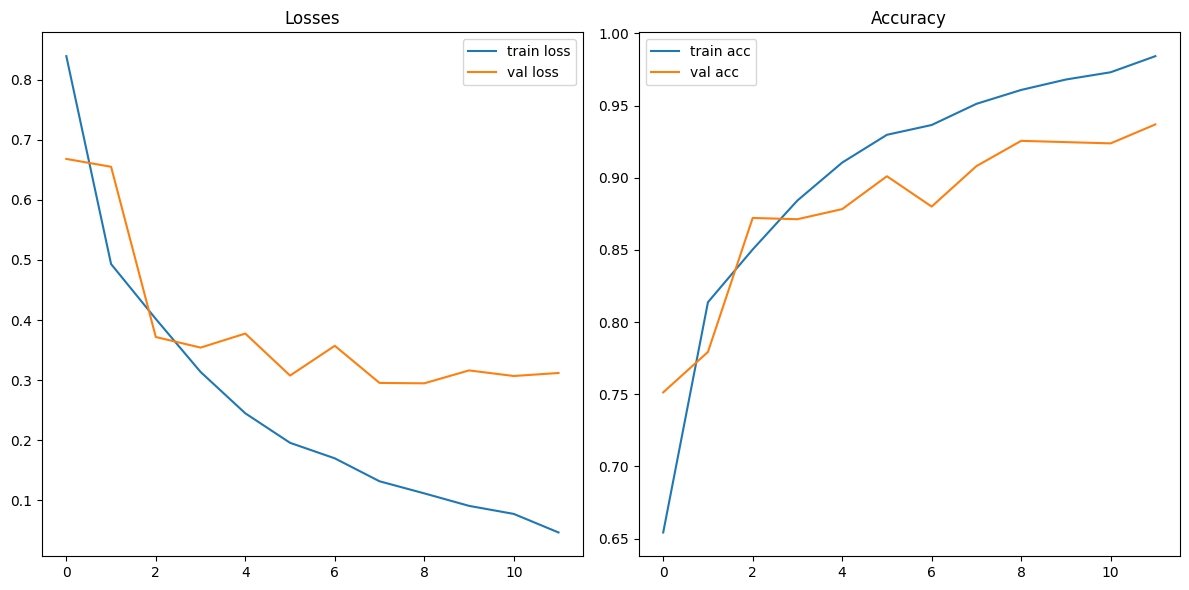

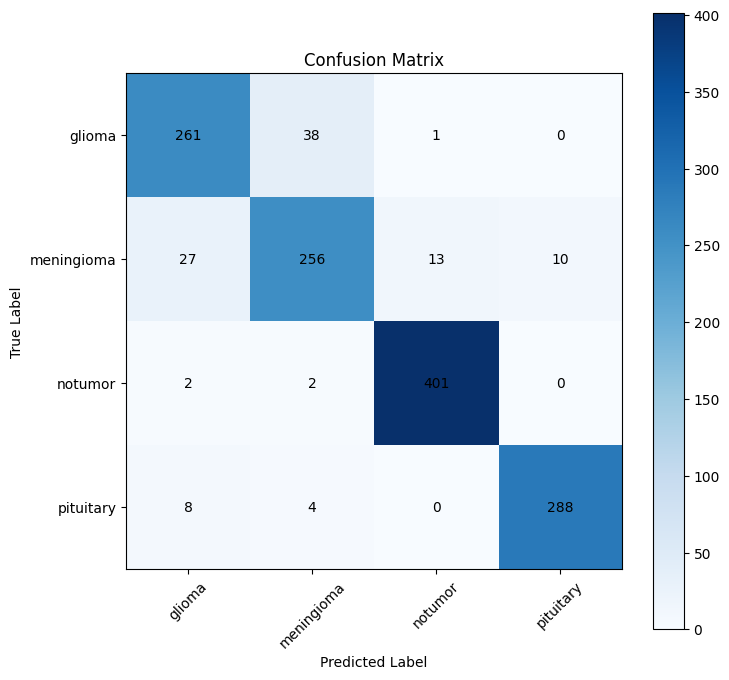

In [44]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# tarin the model

history7 = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history7.history['loss'], label='train loss')
plt.plot(history7.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history7.history['accuracy'], label='train acc')
plt.plot(history7.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions7 = eval_model_on_test(model)

# get the predicted labels

predicted_labels7 = np.argmax(predictions7, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels7, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels7)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()


In [45]:
report7 = classification_report(test_labels, predicted_labels7, target_names=classes, output_dict=True)

recall_dict['CNN_3LD_Flip_UPDOWN'] = report7['meningioma']['recall']
f1_weighted_dict['CNN_3LD_Flip_UPDOWN'] = report7['weighted avg']['f1-score']

In [46]:
f1_weighted_dict


{'CNN_1Layer_Conv2D': 0.9223009470740805,
 'CNN_2Layer_Conv2D': 0.9065875564338557,
 'CNN_3Layer_Conv2D': 0.9562722071903722,
 'CNN_4Layer_Conv2D': 0.9416811581407522,
 'CNN_3LayerDeeper_Conv2D': 0.956874119962932,
 'CNN_4LayerDeeper_Conv2D': 0.9371736237146099,
 'CNN_3LD_Flip_LeftRight': 0.9640613305427111,
 'CNN_3LD_Flip_UPDOWN': 0.919512227280126}

In [47]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),  # Corrected from "left_right" to "horizontal"
  layers.RandomRotation(0.022),    # Assuming you want a rotation factor of approximately 0.041
])


In [48]:
train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


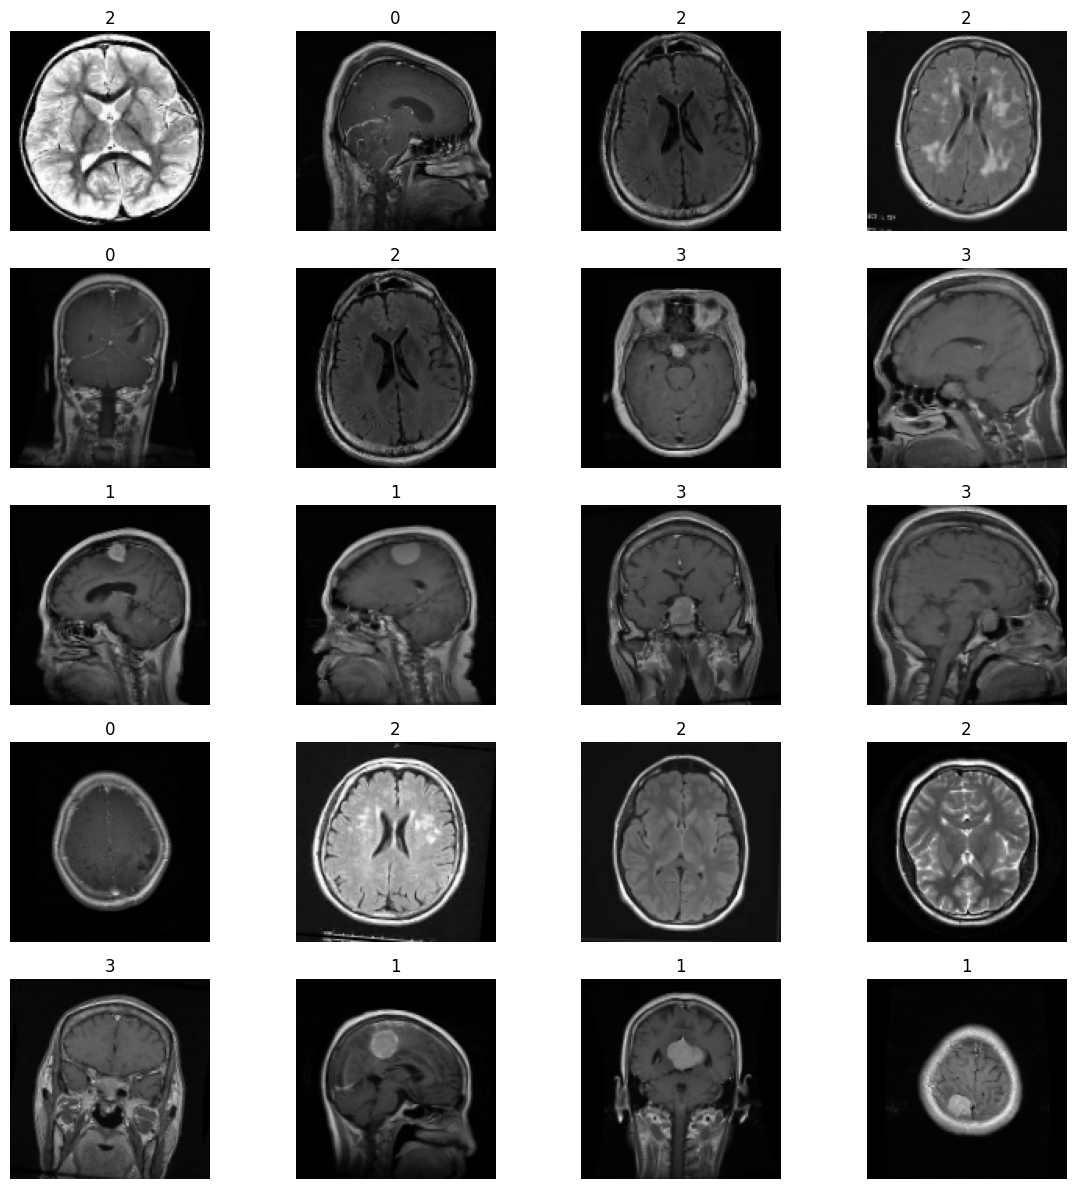

In [49]:
plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

Epoch 1/20
143/143 [==============================] - 17s 98ms/step - loss: 0.7402 - accuracy: 0.6950 - val_loss: 0.7747 - val_accuracy: 0.7320
Epoch 2/20
143/143 [==============================] - 13s 92ms/step - loss: 0.4489 - accuracy: 0.8293 - val_loss: 0.3679 - val_accuracy: 0.8643
Epoch 3/20
143/143 [==============================] - 13s 92ms/step - loss: 0.3209 - accuracy: 0.8770 - val_loss: 0.3012 - val_accuracy: 0.8888
Epoch 4/20
143/143 [==============================] - 13s 92ms/step - loss: 0.2415 - accuracy: 0.9085 - val_loss: 0.4175 - val_accuracy: 0.8616
Epoch 5/20
143/143 [==============================] - 13s 91ms/step - loss: 0.2219 - accuracy: 0.9162 - val_loss: 0.2341 - val_accuracy: 0.9194
Epoch 6/20
143/143 [==============================] - 14s 93ms/step - loss: 0.1529 - accuracy: 0.9422 - val_loss: 0.2215 - val_accuracy: 0.9370
Epoch 7/20
143/143 [==============================] - 13s 92ms/step - loss: 0.1297 - accuracy: 0.9532 - val_loss: 0.3111 - val_accuracy:

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:10,  1.05s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.94it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.96it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.94it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.72it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.16it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.56it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  6.20it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.41it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.90it/s]

1/1 [==============================] - 0s 74ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]

              precision    recall  f1-score   support

      glioma       0.95      0.86      0.90       300
  meningioma       0.85      0.80      0.82       306
     notumor       0.89      0.99      0.94       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.91      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.91      0.91      1311



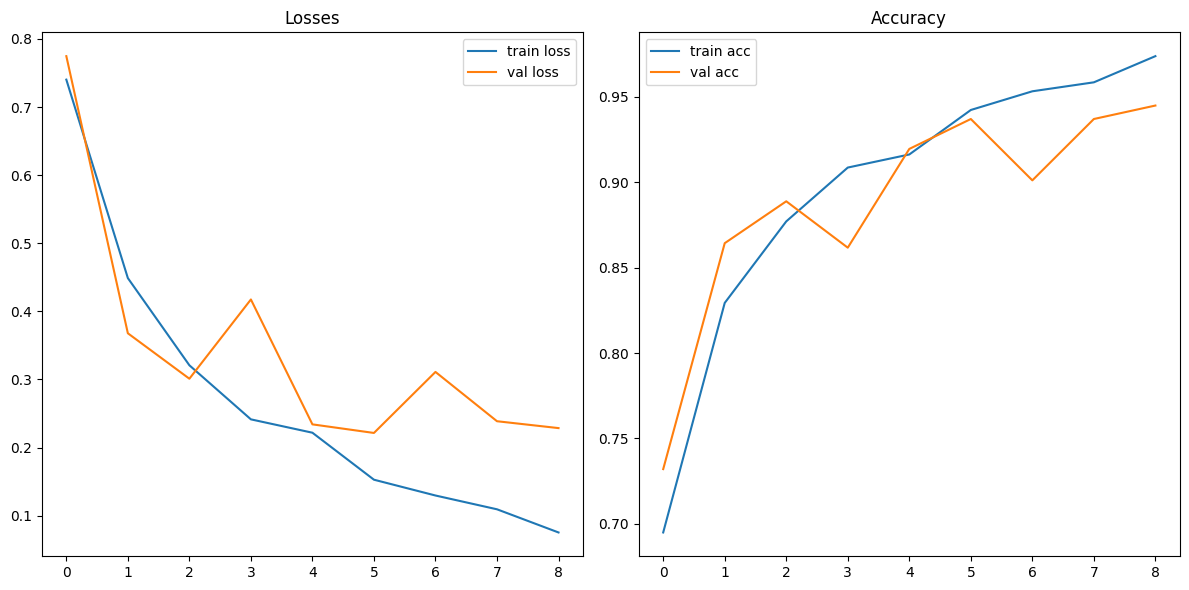

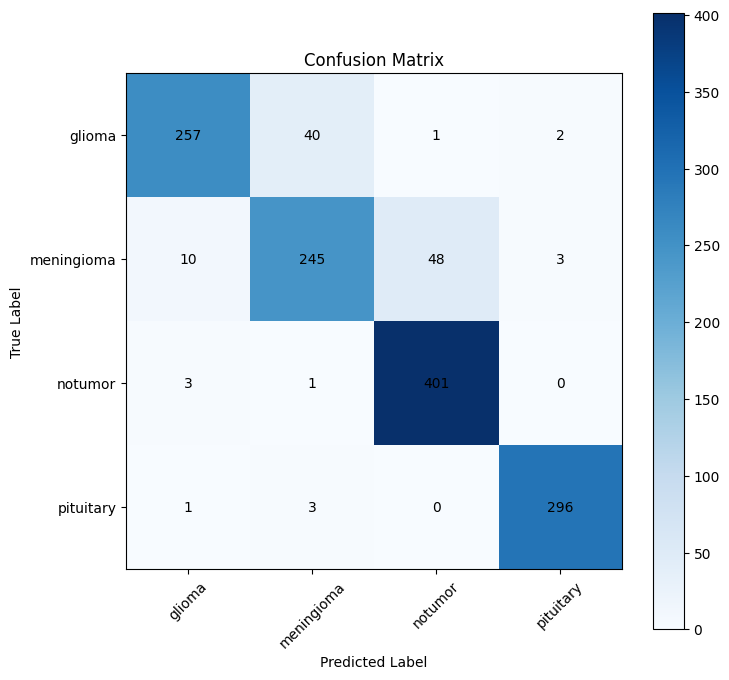

In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# tarin the model

history8 = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history8.history['loss'], label='train loss')
plt.plot(history8.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history8.history['accuracy'], label='train acc')
plt.plot(history8.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions8 = eval_model_on_test(model)

# get the predicted labels

predicted_labels8 = np.argmax(predictions8, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels8, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels8)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()


In [51]:
report9 = classification_report(test_labels, predicted_labels8, target_names=classes, output_dict=True)

recall_dict['CNN_3LD_Flip_LEFTRIGHT_ROT8'] = report9['meningioma']['recall']
f1_weighted_dict['CNN_3LD_Flip_LEFTRIGHT_ROT8'] = report9['weighted avg']['f1-score']

In [52]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.9223009470740805,
 'CNN_2Layer_Conv2D': 0.9065875564338557,
 'CNN_3Layer_Conv2D': 0.9562722071903722,
 'CNN_4Layer_Conv2D': 0.9416811581407522,
 'CNN_3LayerDeeper_Conv2D': 0.956874119962932,
 'CNN_4LayerDeeper_Conv2D': 0.9371736237146099,
 'CNN_3LD_Flip_LeftRight': 0.9640613305427111,
 'CNN_3LD_Flip_UPDOWN': 0.919512227280126,
 'CNN_3LD_Flip_LEFTRIGHT_ROT8': 0.9133903613786859}

In [53]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),  # Corrected from "left_right" to "horizontal"
  layers.RandomContrast(factor=[0.1,0.9], seed=42)
])


In [54]:
train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


Epoch 1/20
143/143 [==============================] - 10s 55ms/step - loss: 0.7573 - accuracy: 0.6974 - val_loss: 0.5499 - val_accuracy: 0.7837
Epoch 2/20
143/143 [==============================] - 9s 59ms/step - loss: 0.4488 - accuracy: 0.8247 - val_loss: 0.5181 - val_accuracy: 0.8240
Epoch 3/20
143/143 [==============================] - 8s 54ms/step - loss: 0.3268 - accuracy: 0.8788 - val_loss: 0.3464 - val_accuracy: 0.8660
Epoch 4/20
143/143 [==============================] - 9s 59ms/step - loss: 0.2318 - accuracy: 0.9149 - val_loss: 0.2481 - val_accuracy: 0.9177
Epoch 5/20
143/143 [==============================] - 7s 50ms/step - loss: 0.1708 - accuracy: 0.9381 - val_loss: 0.4629 - val_accuracy: 0.8231
Epoch 6/20
143/143 [==============================] - 8s 52ms/step - loss: 0.1317 - accuracy: 0.9525 - val_loss: 0.2715 - val_accuracy: 0.9177
Epoch 7/20
143/143 [==============================] - 8s 55ms/step - loss: 0.0888 - accuracy: 0.9691 - val_loss: 0.3736 - val_accuracy: 0.871

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:11,  1.15s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.82it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.80it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.77it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.06it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.39it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  5.69it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.01it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.50it/s]

1/1 [==============================] - 0s 73ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.30it/s]


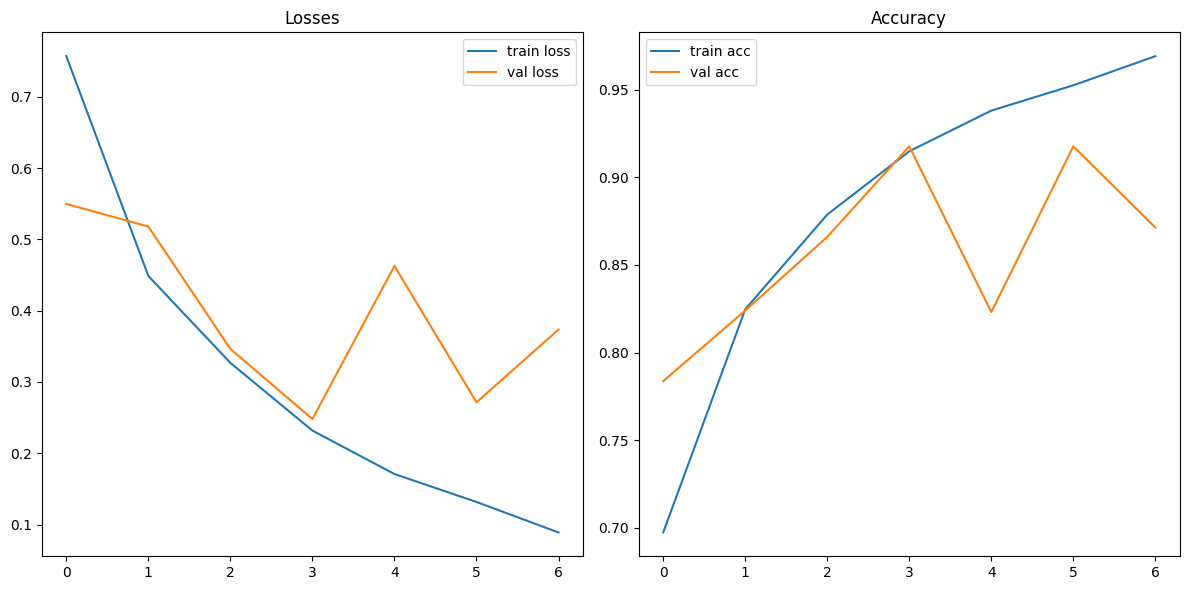

In [55]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# tarin the model

history10 = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history10.history['loss'], label='train loss')
plt.plot(history10.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history10.history['accuracy'], label='train acc')
plt.plot(history10.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions10 = eval_model_on_test(model)

# get the predicted labels

predicted_labels10 = np.argmax(predictions10, axis=1)

report10 = classification_report(test_labels, predicted_labels10, target_names=classes, output_dict=True)

recall_dict['CNN_3LD_Flip_LEFTRIGHT_CONTRAST'] = report10['meningioma']['recall']
f1_weighted_dict['CNN_3LD_Flip_LEFTRIGHT_CONTRAST'] = report10['weighted avg']['f1-score']



In [56]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.9223009470740805,
 'CNN_2Layer_Conv2D': 0.9065875564338557,
 'CNN_3Layer_Conv2D': 0.9562722071903722,
 'CNN_4Layer_Conv2D': 0.9416811581407522,
 'CNN_3LayerDeeper_Conv2D': 0.956874119962932,
 'CNN_4LayerDeeper_Conv2D': 0.9371736237146099,
 'CNN_3LD_Flip_LeftRight': 0.9640613305427111,
 'CNN_3LD_Flip_UPDOWN': 0.919512227280126,
 'CNN_3LD_Flip_LEFTRIGHT_ROT8': 0.9133903613786859,
 'CNN_3LD_Flip_LEFTRIGHT_CONTRAST': 0.9090649826073486}

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),  # Corrected from "left_right" to "horizontal"
  layers.RandomCrop(height=int(0.95*128), width=int(0.95*128)),
  layers.Resizing(128, 128)
])

train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# tarin the model

history11 = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history11.history['loss'], label='train loss')
plt.plot(history11.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history11.history['accuracy'], label='train acc')
plt.plot(history11.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions11 = eval_model_on_test(model)

# get the predicted labels

predicted_labels11 = np.argmax(predictions11, axis=1)

report11 = classification_report(test_labels, predicted_labels11, target_names=classes, output_dict=True)

recall_dict['CNN_3LD_Flip_LEFTRIGHT_CROP5%'] = report11['meningioma']['recall']
f1_weighted_dict['CNN_3LD_Flip_LEFTRIGHT_CROP5%'] = report11['weighted avg']['f1-score']



Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Epoch 1/20
143/143 [==============================] - 10s 55ms/step - loss: 0.8258 - accuracy: 0.6503 - val_loss: 0.6893 - val_accuracy: 0.7303
Epoch 2/20
143/143 [==============================] - 7s 48ms/step - loss: 0.4881 - accuracy: 0.8114 - val_loss: 0.4842 - val_accuracy: 0.8327
Epoch 3/20
143/143 [==============================] - 7s 48ms/step - loss: 0.4147 - accuracy: 0.8407 - val_loss: 0.4700 - val_accuracy: 0.8538
Epoch 4/20
143/143 [==============================] - 7s 48ms/step - loss: 0.3320 - accuracy: 0.8718 - val_loss: 0.3773 - val_accuracy: 0.8870
Epoch 5/20
143/143 [==============================] - 8s 55ms/step - loss: 0.2535 - accuracy: 0.9035 - val_loss: 0.5388 - val_accuracy: 0.8275
Epoch 6/20
143/143 [==============================] - 8s 58ms/step - loss: 0.2428 - accuracy: 0.9118 - val_loss: 0.3414 - val_accuracy: 0.

In [ ]:
f1_weighted_dict

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Epoch 1/20
143/143 [==============================] - 15s 91ms/step - loss: 0.7536 - accuracy: 0.6987 - val_loss: 0.5146 - val_accuracy: 0.8231
Epoch 2/20
143/143 [==============================] - 13s 90ms/step - loss: 0.4333 - accuracy: 0.8370 - val_loss: 0.5947 - val_accuracy: 0.7933
Epoch 3/20
143/143 [==============================] - 13s 92ms/step - loss: 0.3376 - accuracy: 0.8685 - val_loss: 0.3150 - val_accuracy: 0.9019
Epoch 4/20
143/143 [==============================] - 13s 91ms/step - loss: 0.2388 - accuracy: 0.9144 - val_loss: 0.2661 - val_accuracy: 0.9168
Epoch 5/20
143/143 [==============================] - 13s 91ms/step - loss: 0.1648 - accuracy: 0.9425 - val_loss: 0.2717 - val_accuracy: 0.9142
Epoch 6/20
143/143 [==============================] - 13s 91ms/step - loss: 0.1302 - accuracy: 0.9554 - val_loss: 0.2703 - val_accurac

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:11,  1.10s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.76it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.56it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.32it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:01,  4.89it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:02<00:00,  5.25it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  5.74it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  5.87it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.15it/s]

1/1 [==============================] - 0s 80ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]


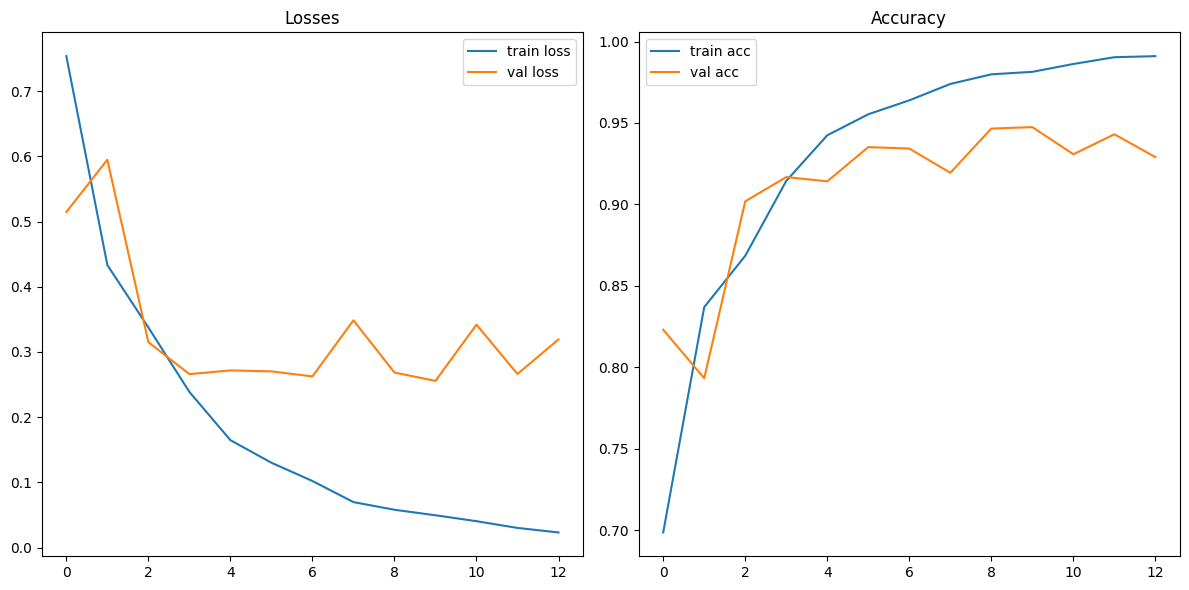

In [59]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),  # Corrected from "left_right" to "horizontal"
  layers.RandomTranslation(height_factor=0.002, width_factor=0.002)
])

train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# tarin the model

history12 = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history12.history['loss'], label='train loss')
plt.plot(history12.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history12.history['accuracy'], label='train acc')
plt.plot(history12.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions12 = eval_model_on_test(model)

# get the predicted labels

predicted_labels12 = np.argmax(predictions12, axis=1)

report12 = classification_report(test_labels, predicted_labels12, target_names=classes, output_dict=True)

recall_dict['CNN_3LD_Flip_LEFTRIGHT_TRANSLATE_002'] = report12['meningioma']['recall']
f1_weighted_dict['CNN_3LD_Flip_LEFTRIGHT_TRANSLATE_002'] = report12['weighted avg']['f1-score']



Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Epoch 1/20
143/143 [==============================] - 10s 55ms/step - loss: 0.7387 - accuracy: 0.6958 - val_loss: 0.5115 - val_accuracy: 0.7986
Epoch 2/20
143/143 [==============================] - 7s 48ms/step - loss: 0.4129 - accuracy: 0.8403 - val_loss: 0.3684 - val_accuracy: 0.8730
Epoch 3/20
143/143 [==============================] - 7s 47ms/step - loss: 0.3166 - accuracy: 0.8823 - val_loss: 0.3052 - val_accuracy: 0.9046
Epoch 4/20
143/143 [==============================] - 9s 59ms/step - loss: 0.2371 - accuracy: 0.9112 - val_loss: 0.2890 - val_accuracy: 0.9116
Epoch 5/20
143/143 [==============================] - 7s 47ms/step - loss: 0.1591 - accuracy: 0.9416 - val_loss: 0.2663 - val_accuracy: 0.9186
Epoch 6/20
143/143 [==============================] - 8s 57ms/step - loss: 0.1159 - accuracy: 0.9582 - val_loss: 0.1990 - val_accuracy: 0.

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:11,  1.12s/it]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.86it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.83it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.60it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.18it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.47it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  5.87it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.46it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.32it/s]

1/1 [==============================] - 0s 75ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.33it/s]


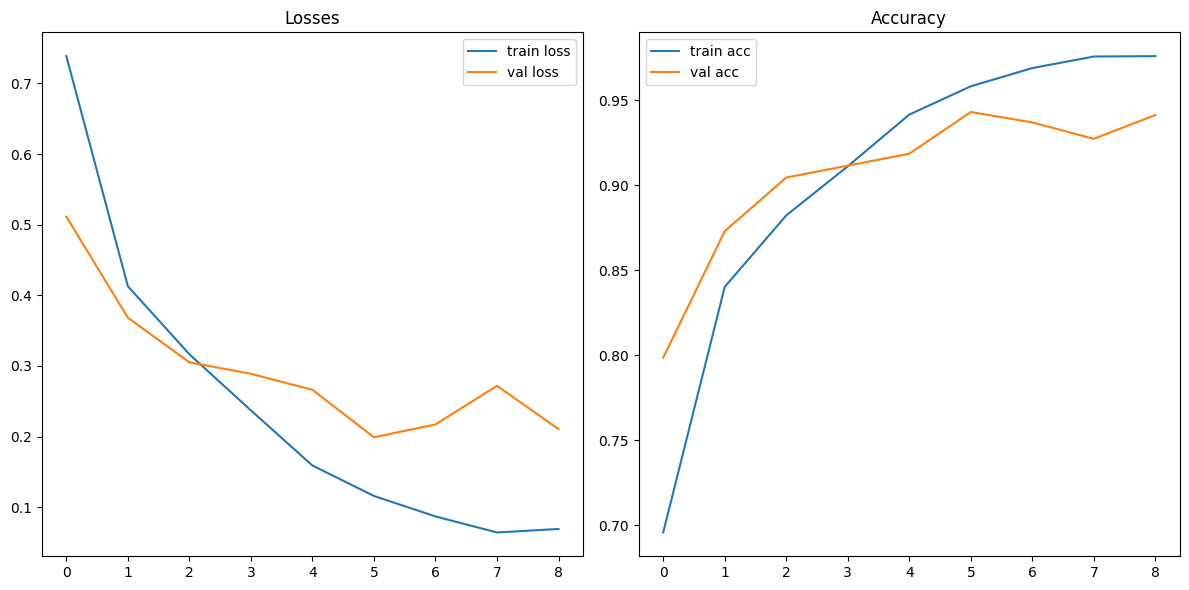

In [60]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),  # Corrected from "left_right" to "horizontal"
  layers.RandomBrightness(factor=0.01)
])

train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# tarin the model

history13 = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history13.history['loss'], label='train loss')
plt.plot(history13.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history13.history['accuracy'], label='train acc')
plt.plot(history13.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions13 = eval_model_on_test(model)

# get the predicted labels

predicted_labels13 = np.argmax(predictions13, axis=1)

report13 = classification_report(test_labels, predicted_labels13, target_names=classes, output_dict=True)

recall_dict['CNN_3LD_Flip_LEFTRIGHT_BRIGHTNESS_0.01'] = report13['meningioma']['recall']
f1_weighted_dict['CNN_3LD_Flip_LEFTRIGHT_BRIGHTNESS_0.01'] = report13['weighted avg']['f1-score']



In [ ]:
{k: round(v, 4) for k, v in sorted(f1_weighted_dict.items(), key=lambda item: item[1], reverse=True)}

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
83683744/83683744 [==============================] - 4s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


143/143 [==============================] - 21s 99ms/step - loss: 4.2868 - accuracy: 0.4254 - val_loss: 1.1886 - val_accuracy: 0.4886
Epoch 2/20
143/143 [==============================] - 9s 64ms/step - loss: 1.3369 - accuracy: 0.4530 - val_loss: 1.1524 - val_accuracy: 0.4956
Epoch 3/20
143/143 [==============================] - 9s 58ms/step - loss: 1.1826 - accuracy: 0.5011 - val_loss: 1.0827 - val_accuracy: 0.5482
Epoch 4/20
143/143 [==============================] - 9s 64ms/step - loss: 1.1094 - accuracy: 0.5190 - val_loss: 1.0282 - val_accuracy: 0.5665
Epoch 5/20
143/143 [==============================] - 9s 62ms/step - loss: 1.0807 - accuracy: 0.5363 - val_loss: 0.9562 - val_accuracy: 0.6077
Epoch 6/20
143/143 [==============================] - 9s 58ms/step - loss: 1.0094 - accuracy: 0.5584 - val_loss: 0.8794 - val_accuracy: 0.6690
Epoch 7/20
143/143 [==============================] - 10s 66ms/step - loss: 0.9729 - accuracy: 0.5895 - val_loss: 0.8406 - val_accuracy: 0.7075
Epoch 8/

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 1s 63ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:02<00:28,  2.89s/it]

4/4 [==============================] - 0s 40ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:03<00:12,  1.44s/it]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:03<00:07,  1.11it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:03<00:04,  1.43it/s]

4/4 [==============================] - 0s 36ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:04<00:03,  1.69it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:04<00:02,  2.09it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:04<00:01,  2.48it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:05<00:01,  2.85it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:05<00:00,  2.76it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:05<00:00,  3.05it/s]

1/1 [==============================] - 2s 2s/step


Predicting on Test Data: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


              precision    recall  f1-score   support

      glioma       0.61      0.65      0.63       300
  meningioma       0.57      0.39      0.46       306
     notumor       0.84      0.86      0.85       405
   pituitary       0.76      0.94      0.84       300

    accuracy                           0.72      1311
   macro avg       0.69      0.71      0.69      1311
weighted avg       0.71      0.72      0.71      1311



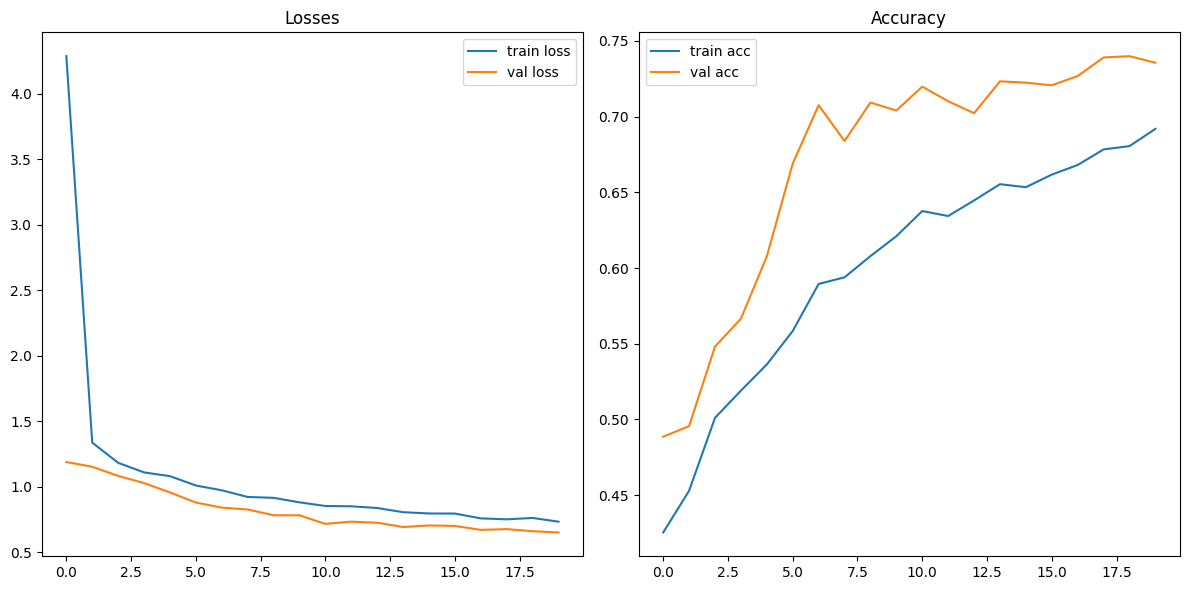

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adamax

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),  # Corrected from "left_right" to "horizontal"
])

train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
# Load the EfficientNetB0 model pre-trained on ImageNet
#base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=(128, 128, 3), pooling='max')

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


history14 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,callbacks= early_stopping_cb
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history14.history['loss'], label='train loss')
plt.plot(history14.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history14.history['accuracy'], label='train acc')
plt.plot(history14.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions14 = eval_model_on_test(model)

# get the predicted labels

predicted_labels14 = np.argmax(predictions14, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels14, target_names=classes))

# save the model
model.save('models/brain_tumor_classifier_v14.keras')

In [ ]:
report14 = classification_report(test_labels, predicted_labels14, target_names=classes, output_dict=True)

recall_dict['XCEPTION_FROZEN'] = report14['meningioma']['recall']
f1_weighted_dict['XCEPTION_FROZEN'] = report14['weighted avg']['f1-score']

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
])

train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=(128, 128, 3), pooling='max')

# Unfreeze all layers in the base model
base_model.trainable = True

# Compile the model after unfreezing the base model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4)
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history14 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=early_stopping_cb
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history14.history['loss'], label='train loss')
plt.plot(history14.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history14.history['accuracy'], label='train acc')
plt.plot(history14.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions14 = eval_model_on_test(model)

# get the predicted labels

predicted_labels14 = np.argmax(predictions14, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels14, target_names=classes))

# save the model
model.save('models/brain_tumor_classifier_v14.keras')


In [ ]:
report14 = classification_report(test_labels, predicted_labels14, target_names=classes, output_dict=True)

recall_dict['XCEPTION_UNFROZEN_ALL'] = report14['meningioma']['recall']
f1_weighted_dict['XCEPTION_UNFROZEN_ALl'] = report14['weighted avg']['f1-score']

In [ ]:
{k: round(v, 4) for k, v in sorted(recall_dict.items(), key=lambda item: item[1], reverse=True)}

In [67]:
cm = confusion_matrix(test_labels, predictions14)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

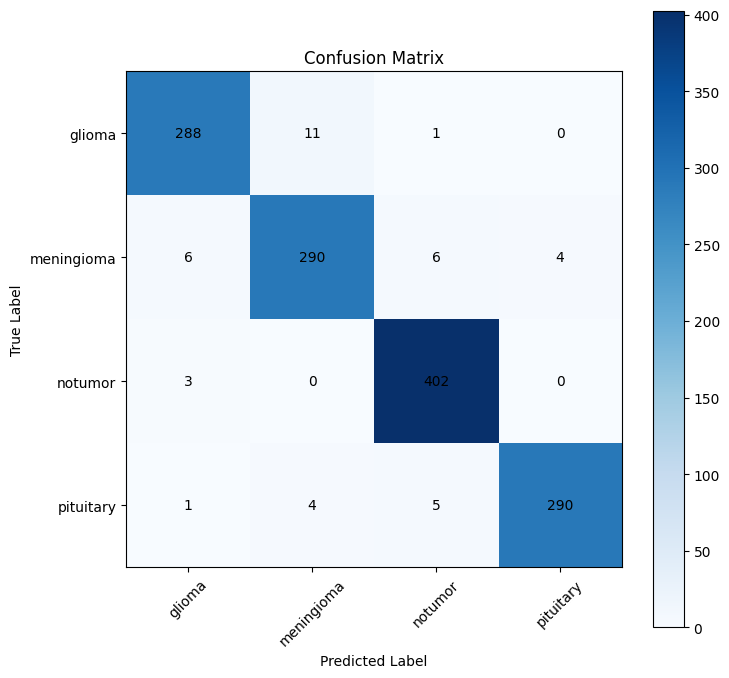

In [68]:
# Convert the predictions to class indices
predicted_labels14 = np.argmax(predictions14, axis=1)

# Get the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels14)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()
